# Linear Regression Using Multi-Layer Perceptron on Salary Prediction Dataset
## Author: Cody Ourique

In [66]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import pathlib
import matplotlib.pyplot as plt
import tensorflow_addons
from tensorflow import keras
from tensorflow_addons.metrics import RSquare
from tensorflow.keras import layers


## Data Preprocessing

### Data Understanding

In [55]:
data = pd.read_csv("Salary Data.csv")
data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [67]:
data.describe()

,Age,Years of Experience,Salary,Gender_Encoded,Education_Encoded
count,373.000000,373.000000,373.000000,373.000000,373.000000
mean,37.431635,10.030831,100577.345845,0.520107,0.536193
std,7.069073,6.557007,48240.013482,0.500267,0.723569
min,23.000000,0.000000,350.000000,0.000000,0.000000
25%,31.000000,4.000000,55000.000000,0.000000,0.000000
50%,36.000000,9.000000,95000.000000,1.000000,0.000000
75%,44.000000,15.000000,140000.000000,1.000000,1.000000
max,53.000000,25.000000,250000.000000,1.000000,2.000000


In [56]:
data.dropna(inplace=True)
data.isna().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

### Feature Selection

,Years of Experience,Salary,Education_Encoded
0,5.0,90000.0,0
1,3.0,65000.0,1
2,15.0,150000.0,2
3,7.0,60000.0,0
4,20.0,200000.0,1


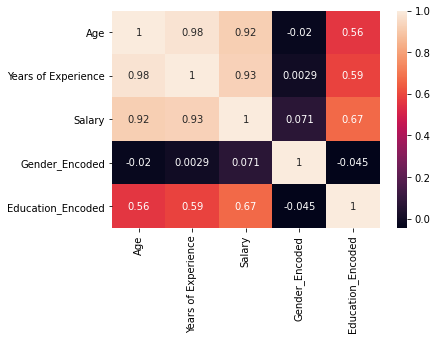

In [57]:
# Encode the categorical data
data['Gender_Encoded'] = data['Gender'].map({'Female': 0, 'Male': 1})
data.drop(columns=['Gender'], inplace=True)

# Create map for tenary encoding
education_mapping = {
    "Bachelor's": 0,
    "Master's": 1,
    "PhD": 2
}

# Perform ternary encoding
data['Education_Encoded'] = data['Education Level'].map(education_mapping)
data.drop(columns=['Education Level'], inplace=True)

data_non_numeric = data.select_dtypes(exclude=['number'])
data_encoded = pd.get_dummies(data_non_numeric, dtype = float)
data_numeric = data.select_dtypes(include=['number'])
targets = pd.DataFrame(data["Salary"])

# Check for multicollinearity amongst numerical values
correlation_matrix = data_numeric.corr()
sns.heatmap(correlation_matrix, annot=True)

# Drop Age because it is highly correlated with Years of Experience and Years
# of Experience is more correlated with our target Salary 
data_numeric.drop(columns=['Age'], inplace=True)

# Drop gender because it is very loosley correlated to the dependent variable
data_numeric.drop(columns=['Gender_Encoded'], inplace=True)

# Drop Job Title due to complexity
data_non_numeric.drop(columns=['Job Title'], inplace=True)

# Concatenate the transformed data
data_final = pd.concat([data_non_numeric, data_numeric], axis=1)
data_final.head()

In [58]:
# train/test split
train = data_final.sample(frac=0.8, random_state=0)
test = data_final.drop(train.index)

# Save and drop the labels from the train and test data frame
train_labels = pd.DataFrame(train["Salary"])
train = train.drop(columns=["Salary"])
test_labels = pd.DataFrame(test["Salary"])
test = test.drop(columns=["Salary"])

# Add normilization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train))
print(normalizer.mean.numpy())

[[9.921141   0.54362416]]


Index(['Years of Experience', 'Salary', 'Education_Encoded'], dtype='object')


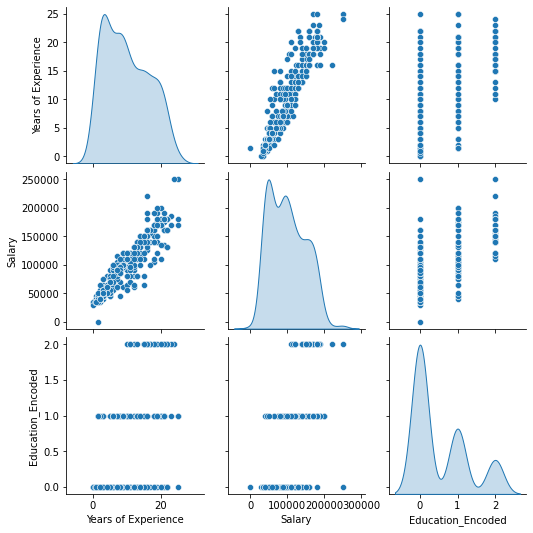

In [59]:
# Look at the correlation between variables 
sns.pairplot(data_final[data_final.columns], diag_kind="kde")
print(data_final.columns)

## Model Configuration

In [60]:
# Build the model
model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

model.compile(
    loss='mae',
    optimizer=optimizer,
    metrics=['mse','mae', RSquare()]
)

model.summary()

callback = keras.callbacks.EarlyStopping(monitor='loss' , patience=7)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 2)                 5         
 tion)                                                           
                                                                 
 dense_8 (Dense)             (None, 64)                192       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6470 (25.28 KB)
Trainable params: 6465 (25.25 KB)
Non-trainable params: 5 (24.00 Byte)
___________________

In [61]:
# Test model on a batch of data
example_batch = train[:10]
example_batch = example_batch.to_numpy()
print(example_batch)
example_batch = tf.convert_to_tensor(example_batch)
example_result = model.predict(example_batch)
example_result

[[ 2.  0.]
 [ 2.  0.]
 [ 3.  0.]
 [16.  1.]
 [ 8.  0.]
 [16.  2.]
 [ 4.  0.]
 [14.  1.]
 [ 2.  0.]
 [21.  1.]]
1/1 [==============================] - 0s 84ms/step


array([[0.04781418],
       [0.04781418],
       [0.05424425],
       [0.03223746],
       [0.03498804],
       [0.1591934 ],
       [0.05507609],
       [0.04406669],
       [0.04781418],
       [0.08531974]], dtype=float32)

## Training the Model

In [62]:
history = model.fit(
    train, train_labels, epochs = 1000, validation_split=0.2, verbose=0, callbacks = [callback]
)

In [63]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,r_square,val_loss,val_mse,val_mae,val_r_square,epoch
22,10917.408203,234440880.0,10917.408203,0.900815,12771.365234,309155648.0,12771.365234,0.854581,22
23,10720.830078,222602192.0,10720.830078,0.905823,12932.645508,329348224.0,12932.645508,0.845083,23
24,11684.821289,252164560.0,11684.821289,0.893316,14043.775391,381430880.0,14043.775391,0.820585,24
25,11796.777344,256060576.0,11796.777344,0.891668,13631.437500,351583360.0,13631.437500,0.834625,25
26,11803.653320,259425040.0,11803.653320,0.890245,12838.626953,313744000.0,12838.626953,0.852423,26


## Model Evaluation

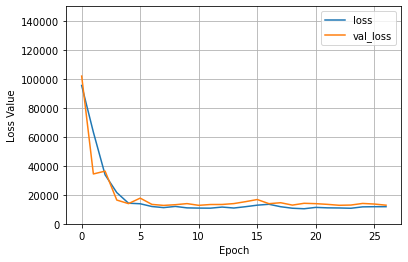

In [64]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0,150000])
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

In [65]:
loss, mse, mae, rs = model.evaluate(test, test_labels,verbose=0)

print(f'Testing set mean absolute error: {mae}\n')
print(f'Testing set mean squared error: {mse}\n')
print(f'Testing set loss: {loss}\n')
print(f'Testing set R squared score: {rs}')

Testing set mean absolute error: 13970.6728515625

Testing set mean squared error: 371678784.0

Testing set loss: 13970.6728515625

Testing set R squared score: 0.8296704292297363
